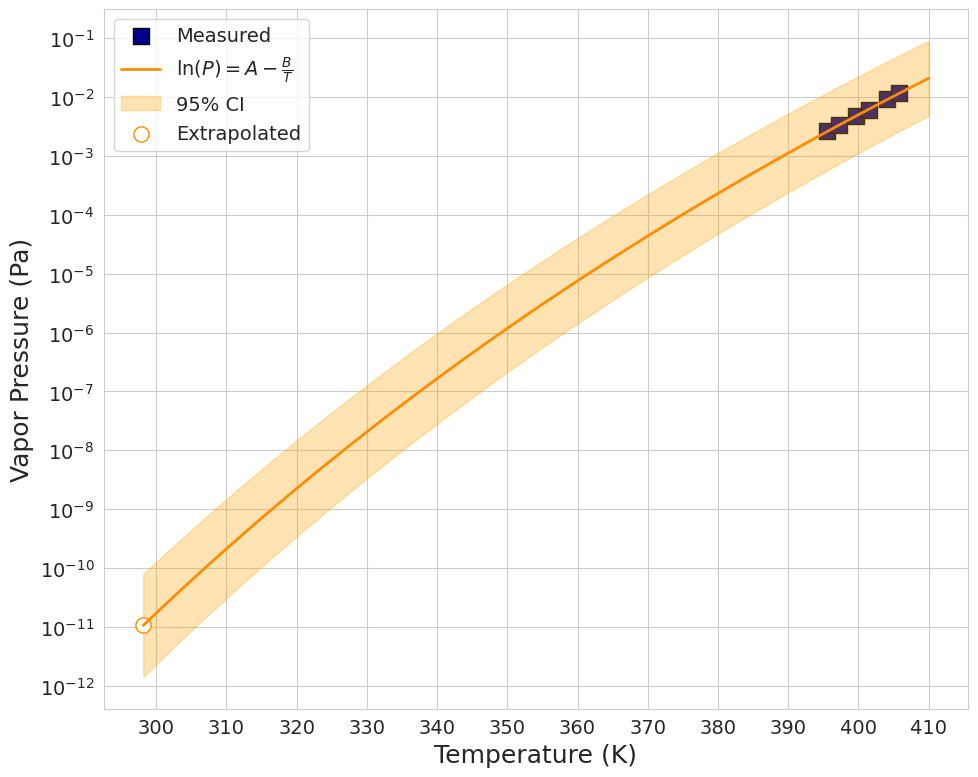

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

measured_vps = [0.00260, 0.00337, 0.00471, 0.00606, 0.00912, 0.0116]
measured_temps = [395.55, 397.29, 399.67, 401.47, 404.12, 405.78]

def Get_VP_from_Clausius_Clapeyron(A, B, T_K, B_std=None):
    ln_P_pa = A - B / T_K
    P_pa = np.exp(ln_P_pa)
    if B_std:
        ln_P_pa_upper = A - (B + B_std) / T_K
        P_pa_upper = np.exp(ln_P_pa_upper)
        ln_P_pa_lower = A - (B - B_std) / T_K
        P_pa_lower = np.exp(ln_P_pa_lower)
        return P_pa, P_pa_upper, P_pa_lower
    return P_pa

A_d_glucose = 53.16
B_d_glucose_mean = 23383
B_d_glucose_std = 600

T_K = 298.15

sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(10, 8))

# Plot measured data
ax.scatter(measured_temps, measured_vps, label='Measured', s=120, marker='s', color='darkblue', edgecolor='black')

# Calculate and plot the model fit
T_K_range = np.linspace(298.15, 410, 100)
vps = [Get_VP_from_Clausius_Clapeyron(A_d_glucose, B_d_glucose_mean, T, B_std=B_d_glucose_std) for T in T_K_range]
vp_means = [vp[0] for vp in vps]
vp_upper = [vp[1] for vp in vps]
vp_lower = [vp[2] for vp in vps]

ax.plot(T_K_range, vp_means, label=r'$\ln(P) = A - \frac{B}{T}$', linewidth=2, linestyle='-', color='darkorange')
ax.fill_between(T_K_range, vp_lower, vp_upper, color='orange', alpha=0.3, label='95% CI')

# Highlight the extrapolated point
extrapolated_vp = Get_VP_from_Clausius_Clapeyron(A_d_glucose, B_d_glucose_mean, 298.15, B_std=B_d_glucose_std)[0]
ax.scatter(298.15, extrapolated_vp, label='Extrapolated', s=120, marker='o', color='white', edgecolor='darkorange')

# Customize the plot appearance
ax.set_xlabel('Temperature (K)', fontsize=18)
ax.set_ylabel('Vapor Pressure (Pa)', fontsize=18)
ax.set_yscale('log')
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=14, loc='upper left')
#set y ticks at every 1 log unit
ax.get_yaxis().set_major_locator(plt.LogLocator(numticks=12))
#and every 10 degrees 
ax.get_xaxis().set_major_locator(plt.MultipleLocator(10))

# # Optional: Add annotation for key points
# ax.annotate('Extrapolated Point', xy=(298.15, extrapolated_vp), xytext=(305, extrapolated_vp * 1.5),
#             arrowprops=dict(arrowstyle='->', lw=1.5), fontsize=12)

plt.tight_layout()
plt.savefig('VP_extrapolation_with_CI_paper.png', dpi=800)
plt.show()


# Overlap datasets

In [3]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem.MolStandardize import rdMolStandardize

#load mols and vapor pressures from sdf: /localhome/cschiebroek/MDFPs/mdfptools/carl/data_curation/sandbox/S01. Compounds List for logVP Calculations.sdf
mols,smiles,vps = [],[],[]
for mol in Chem.SDMolSupplier('/home/cschiebroek/Downloads/molecules-1089923-SM-proofed/S01. Compounds List for logVP Calculations.sdf'):
    if mol:
        mols.append(mol)
        smiles.append(Chem.MolToSmiles(mol))
        vps.append(mol.GetProp('logVP'))
    else:
        print('mol is None')
print(len(mols))
df_naef = pd.DataFrame({'SMILES':smiles, 'VP logPa':vps})
df_naef['standardized_smiles'] = df_naef.apply(lambda row: Chem.MolToSmiles(rdMolStandardize.ChargeParent(Chem.MolFromSmiles((row['SMILES'])))), axis=1)
df_naef['inchikey'] = df_naef.apply(lambda row: Chem.MolToInchiKey(Chem.MolFromSmiles((row['standardized_smiles']))), axis=1)


opera_mols_25,opera_vps_25,opera_smiles_25 = [],[],[]
#/localhome/cschiebroek/MDFPs/mdfptools/carl/data_curation/OPERA_Data/VP_QR.sdf
for mol in Chem.SDMolSupplier('/localhome/cschiebroek/MDFP_VP/mdfptools/carl/data_curation/OPERA_Data/VP_QR.sdf'):
    if mol.GetProp('VP Temperature') == '25':
        opera_mols_25.append(mol)
        opera_smiles_25.append(Chem.MolToSmiles(mol))
        opera_vps_25.append(mol.GetProp('LogVP'))

df_opera = pd.DataFrame({'SMILES':opera_smiles_25, 'VP log mmHg':opera_vps_25})
df_opera['VP mmHg'] = df_opera['VP log mmHg'].apply(lambda x: 10**float(x))
df_opera['VP Pa'] = df_opera['VP mmHg'].apply(lambda x: x*133.322)
df_opera['VP logPa'] = df_opera['VP Pa'].apply(lambda x: np.log10(x))
df_opera = df_opera.drop(columns=['VP Pa','VP mmHg'])

df_opera['standardized_smiles'] = df_opera.apply(lambda row: Chem.MolToSmiles(rdMolStandardize.ChargeParent(Chem.MolFromSmiles((row['SMILES'])))), axis=1)
df_opera['inchikey'] = df_opera.apply(lambda row: Chem.MolToInchiKey(Chem.MolFromSmiles(row['standardized_smiles'])), axis=1)

#for overlapping inchikeys; plot the vapor pressures against eachother
import seaborn as sns
inchikeys_opera = set(df_opera['inchikey'])
inchikeys_naef = set(df_naef['inchikey'])
overlap = inchikeys_opera.intersection(inchikeys_naef)
vps_naef,vps_opera = [],[]
for inchikey in overlap:
    vp_naef = df_naef[df_naef['inchikey'] == inchikey]['VP logPa'].values[0]
    vp_opera = df_opera[df_opera['inchikey'] == inchikey]['VP logPa'].values[0]
    vps_naef.append(vp_naef)
    vps_opera.append(vp_opera)
vps_naef = [float(vp) for vp in vps_naef]
vps_opera = [float(vp) for vp in vps_opera]

[11:34:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[11:34:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[11:34:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[11:34:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[11:34:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[11:34:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[11:34:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[11:34:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[11:34:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

mol is None
2071


[11:34:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[11:34:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[11:34:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[11:34:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[11:34:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[11:34:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[11:34:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[11:34:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[11:34:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is 

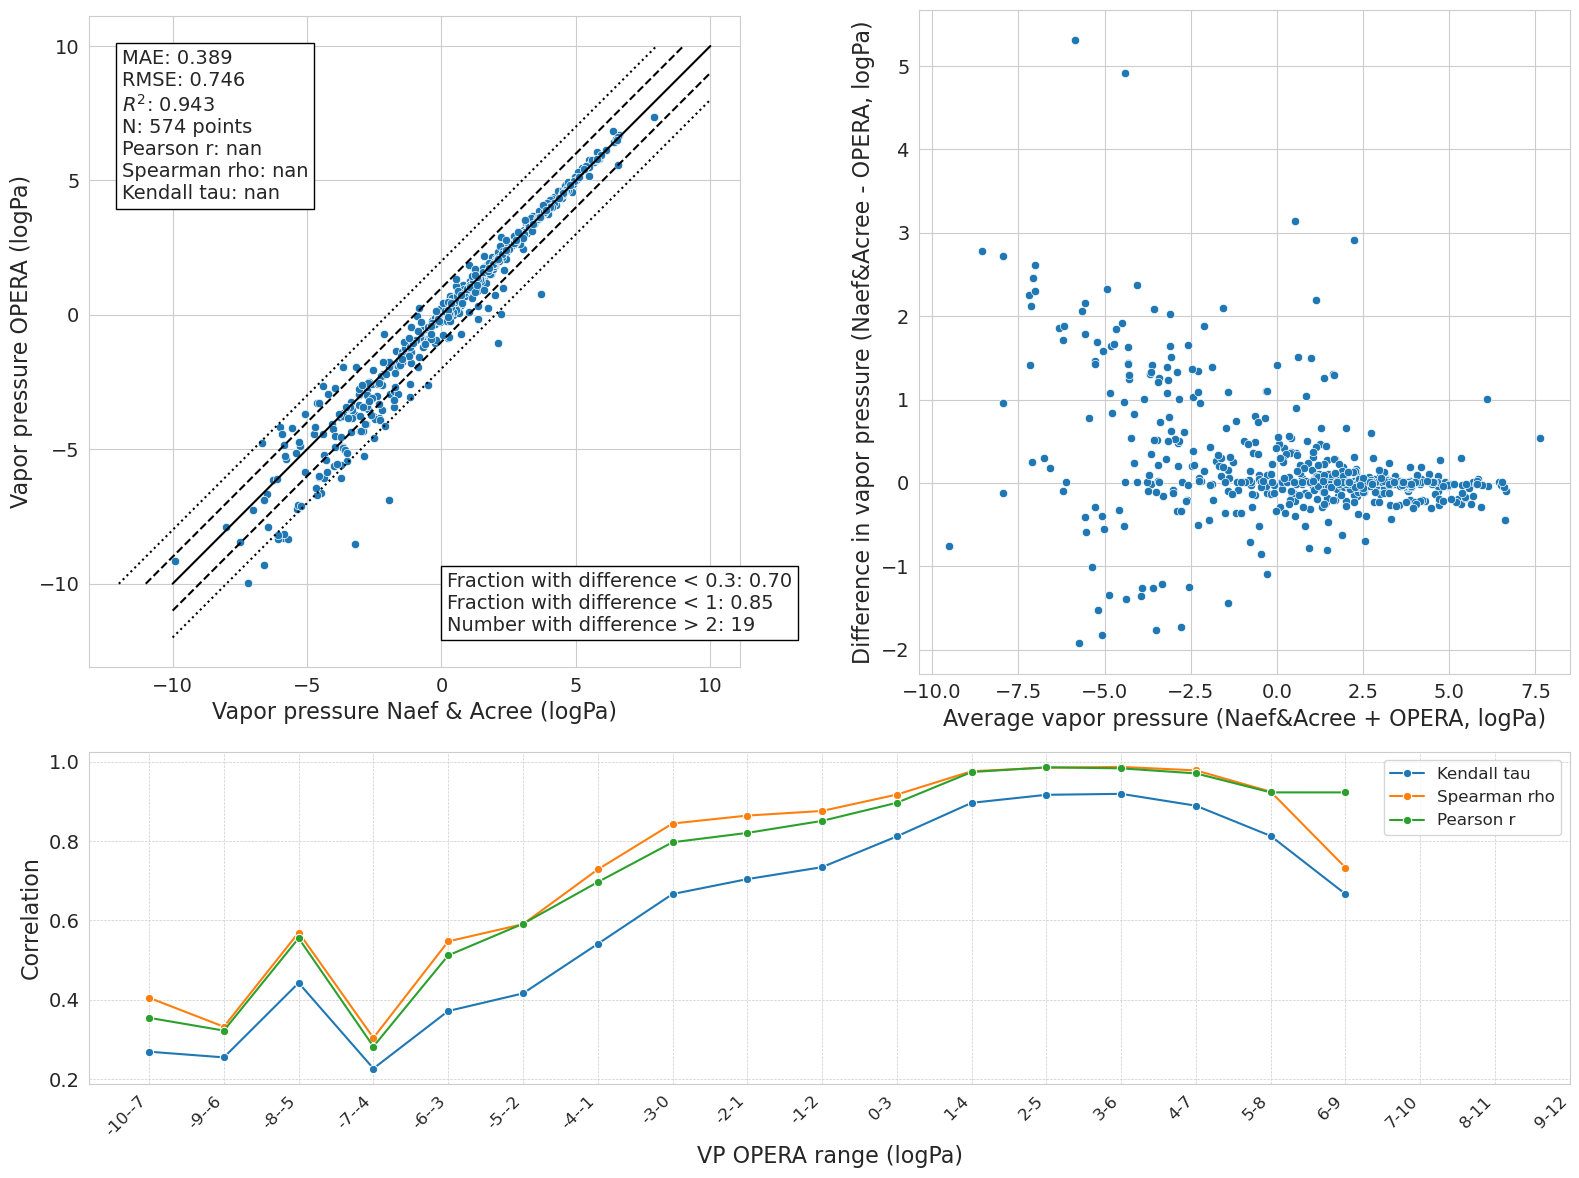

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr, kendalltau

# Prepare data: Remove exact duplicates
vps_naef_no_exact_duplicates, vps_opera_no_exact_duplicates = [], []
for i in range(len(vps_naef)):
    if abs(vps_naef[i] - vps_opera[i]) > 0.01:
        vps_naef_no_exact_duplicates.append(vps_naef[i])
        vps_opera_no_exact_duplicates.append(vps_opera[i])

# Calculate statistics
mae = mean_absolute_error(vps_naef_no_exact_duplicates, vps_opera_no_exact_duplicates)
rmse = np.sqrt(mean_squared_error(vps_naef_no_exact_duplicates, vps_opera_no_exact_duplicates))
r2 = r2_score(vps_naef_no_exact_duplicates, vps_opera_no_exact_duplicates)
pearson = pearsonr(vps_naef_no_exact_duplicates, vps_opera_no_exact_duplicates)
spearman = spearmanr(vps_naef_no_exact_duplicates, vps_opera_no_exact_duplicates)
kendall = kendalltau(vps_naef_no_exact_duplicates, vps_opera_no_exact_duplicates)

fraction_exactly_same = len([1 for i in range(len(vps_naef_no_exact_duplicates)) if abs(vps_naef_no_exact_duplicates[i] - vps_opera_no_exact_duplicates[i]) < 0.01]) / len(vps_naef_no_exact_duplicates)
fraction_within_03 = len([1 for i in range(len(vps_naef_no_exact_duplicates)) if abs(vps_naef_no_exact_duplicates[i] - vps_opera_no_exact_duplicates[i]) < 0.3]) / len(vps_naef_no_exact_duplicates)
fraction_within_1 = len([1 for i in range(len(vps_naef_no_exact_duplicates)) if abs(vps_naef_no_exact_duplicates[i] - vps_opera_no_exact_duplicates[i]) < 1]) / len(vps_naef_no_exact_duplicates)
number_larger_2 = len([1 for i in range(len(vps_naef_no_exact_duplicates)) if abs(vps_naef_no_exact_duplicates[i] - vps_opera_no_exact_duplicates[i]) > 2])

# Prepare data for Bland-Altman plot
average_vps_no_exact_dups = [(vps_naef_no_exact_duplicates[i] + vps_opera_no_exact_duplicates[i]) / 2 for i in range(len(vps_naef_no_exact_duplicates))]
difference_vps_no_exact_dups = [vps_naef_no_exact_duplicates[i] - vps_opera_no_exact_duplicates[i] for i in range(len(vps_naef_no_exact_duplicates))]

#save vps_naef_no_exact_duplicates and vps_opera_no_exact_duplicates to csv
df = pd.DataFrame({'VP Naef&Acree':vps_naef_no_exact_duplicates, 'VP OPERA':vps_opera_no_exact_duplicates})
df.to_csv('vapor_pressures_naef_opera_duplicates.csv', index=False)
# Correlation calculations over dataset sections
correlations = []
xticklabels = []
x_positions = []

for i in range(-10, 10):
    try:
        df_temp = pd.DataFrame({'VP Naef&Acree': vps_naef_no_exact_duplicates, 'VP OPERA': vps_opera_no_exact_duplicates})
        df_temp = df_temp[(df_temp['VP OPERA'] >= i) & (df_temp['VP OPERA'] < i + 3)]
        pearson = pearsonr(df_temp['VP Naef&Acree'], df_temp['VP OPERA'])
        spearman = spearmanr(df_temp['VP Naef&Acree'], df_temp['VP OPERA'])
        kendall = kendalltau(df_temp['VP Naef&Acree'], df_temp['VP OPERA'])
    except ValueError:
        pearson = (np.nan, np.nan)
        spearman = (np.nan, np.nan)
        kendall = (np.nan, np.nan)

    correlations.append([i, i + 3, pearson[0], spearman[0], kendall[0]])
    xticklabels.append(f'{i}-{i + 3}')
    x_positions.append(i + 1.5)

correlations_df = pd.DataFrame(correlations, columns=['VP OPERA range', 'VP OPERA range + 3', 'Pearson', 'Spearman', 'Kendall'])
#save
correlations_df.to_csv('correlations_opera_naef.csv', index=False)
# Create figure layout with gridspec
fig = plt.figure(constrained_layout=True, figsize=(16, 12))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 0.5])

# Scatter plot
ax1 = fig.add_subplot(gs[0, 0])
sns.scatterplot(ax=ax1, x=vps_naef_no_exact_duplicates, y=vps_opera_no_exact_duplicates)
ax1.plot([-10, 10], [-10, 10], color='black', label='Equality line')
ax1.plot([-10, 10], [-11, 9], color='black', linestyle='dashed', label='±1 log unit')
ax1.plot([-11, 9], [-10, 10], color='black', linestyle='dashed')
ax1.plot([-10, 10], [-12, 8], color='black', linestyle='dotted', label='±2 log units')
ax1.plot([-12, 8], [-10, 10], color='black', linestyle='dotted')

text_box = ax1.text(
    0.05, 0.95,
    f'MAE: {mae:.3f}\nRMSE: {rmse:.3f}\n$R^2$: {r2:.3f}\nN: {len(vps_naef_no_exact_duplicates)} points\n'
    f'Pearson r: {pearson[0]:.3f}\nSpearman rho: {spearman[0]:.3f}\nKendall tau: {kendall[0]:.3f}',
    transform=ax1.transAxes,
    verticalalignment='top',
    bbox=dict(facecolor='white', edgecolor='black')
)

text_box = ax1.text(
    0.55, 0.05,
    f'Fraction with difference < 0.3: {fraction_within_03:.2f}\n'
    f'Fraction with difference < 1: {fraction_within_1:.2f}\nNumber with difference > 2: {number_larger_2}',
    transform=ax1.transAxes,
    verticalalignment='bottom',
    bbox=dict(facecolor='white', edgecolor='black')
)

ax1.set_xlabel('Vapor pressure Naef & Acree (logPa)', fontsize=16)
ax1.set_ylabel('Vapor pressure OPERA (logPa)', fontsize=16)
ax1.tick_params(axis='both', labelsize=14)
ax1.set_aspect('equal', 'box')
ax1.grid(True)

# Bland-Altman plot
ax2 = fig.add_subplot(gs[0, 1])
sns.scatterplot(ax=ax2, x=average_vps_no_exact_dups, y=difference_vps_no_exact_dups)
ax2.set_xlabel('Average vapor pressure (Naef&Acree + OPERA, logPa)', fontsize=16)
ax2.set_ylabel('Difference in vapor pressure (Naef&Acree - OPERA, logPa)', fontsize=16)
ax2.tick_params(axis='both', labelsize=14)
ax2.grid(True)

# Correlation plot
ax3 = fig.add_subplot(gs[1, :])
sns.lineplot(x=x_positions, y=correlations_df['Kendall'], label='Kendall tau', ax=ax3, marker='o')
sns.lineplot(x=x_positions, y=correlations_df['Spearman'], label='Spearman rho', ax=ax3, marker='o')
sns.lineplot(x=x_positions, y=correlations_df['Pearson'], label='Pearson r', ax=ax3, marker='o')

ax3.set_xlabel('VP OPERA range (logPa)', fontsize=16)
ax3.set_ylabel('Correlation', fontsize=16)
ax3.set_xticks(x_positions)
ax3.set_xticklabels(xticklabels, fontsize=12, rotation=45, ha='right')
ax3.tick_params(axis='y', labelsize=14)
ax3.grid(visible=True, linestyle='--', linewidth=0.5)
ax3.legend(fontsize=12)

# Save and show the plot
plt.tight_layout()
plt.savefig('vapor_pressure_comparison_combined_with_correlation.png', dpi=800)
plt.show()


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


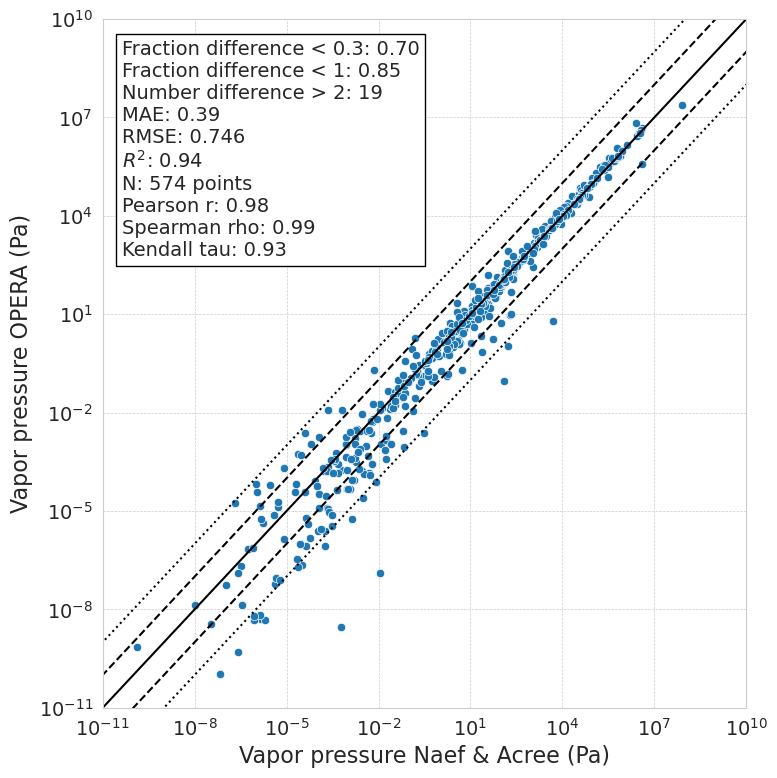

/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/tmp/ipykernel_1826983/2690503718.py:90: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(ylabels)
/tmp/ipykernel_1826983/2690503718.py:91: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(-11, 10)


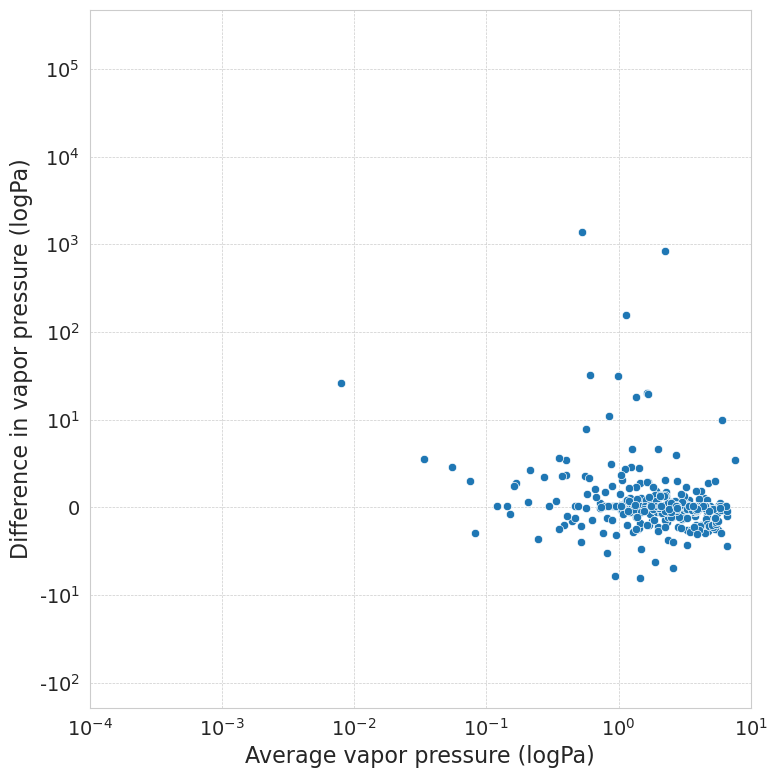

/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na 

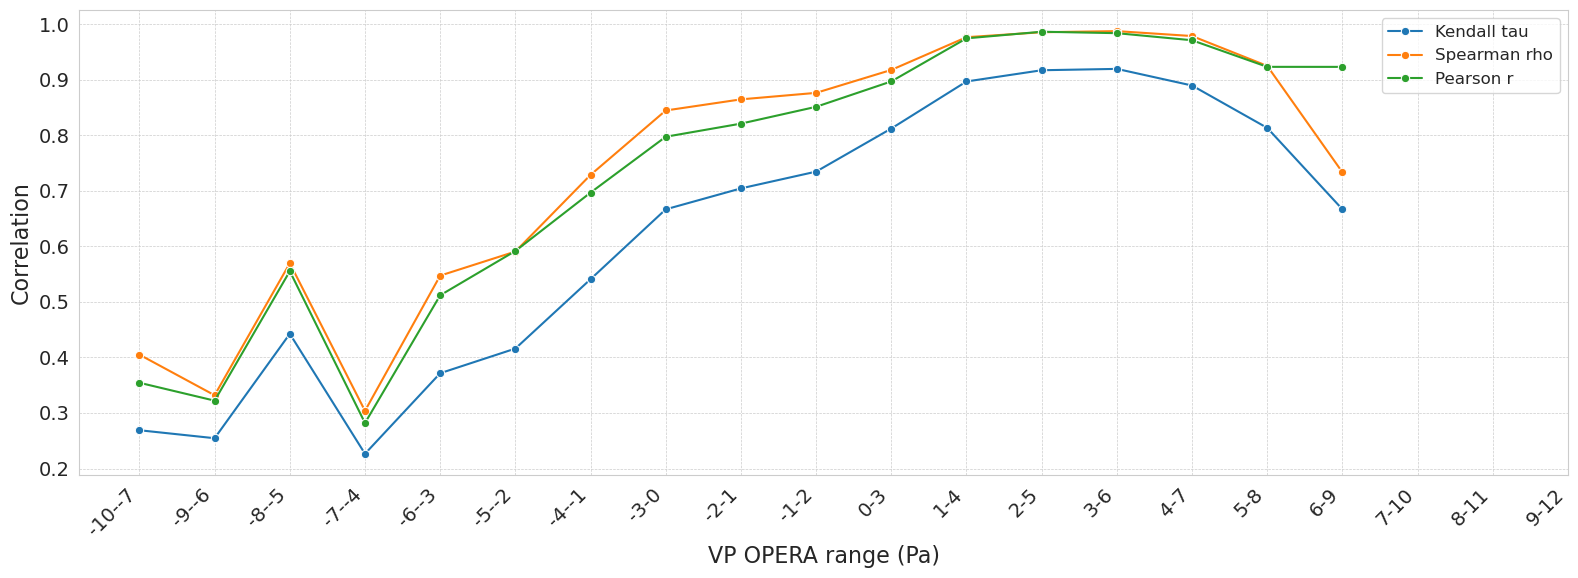

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr, kendalltau
import pandas as pd

# Set global font size for consistency
plt.rcParams.update({
    'font.size': 14,       # General font size
    'axes.labelsize': 16,  # Font size for axis labels
    'axes.titlesize': 16,  # Font size for titles
    'xtick.labelsize': 14, # Font size for x-tick labels
    'ytick.labelsize': 14, # Font size for y-tick labels
    'legend.fontsize': 12, # Font size for legends
})

# Prepare data: Remove exact duplicates
vps_naef_no_exact_duplicates, vps_opera_no_exact_duplicates = [], []
for i in range(len(vps_naef)):
    if abs(vps_naef[i] - vps_opera[i]) > 0.01:
        vps_naef_no_exact_duplicates.append(vps_naef[i])
        vps_opera_no_exact_duplicates.append(vps_opera[i])

# Transform data to Pascal scale
vps_naef_no_exact_duplicates_pa = [10**vp for vp in vps_naef_no_exact_duplicates]
vps_opera_no_exact_duplicates_pa = [10**vp for vp in vps_opera_no_exact_duplicates]

# Calculate statistics (still using logPa scale for consistency in statistics)
mae = mean_absolute_error(vps_naef_no_exact_duplicates, vps_opera_no_exact_duplicates)
rmse = np.sqrt(mean_squared_error(vps_naef_no_exact_duplicates, vps_opera_no_exact_duplicates))
r2 = r2_score(vps_naef_no_exact_duplicates, vps_opera_no_exact_duplicates)
pearson = pearsonr(vps_naef_no_exact_duplicates, vps_opera_no_exact_duplicates)
spearman = spearmanr(vps_naef_no_exact_duplicates, vps_opera_no_exact_duplicates)
kendall = kendalltau(vps_naef_no_exact_duplicates, vps_opera_no_exact_duplicates)

fraction_within_03 = len([1 for i in range(len(vps_naef_no_exact_duplicates)) if abs(vps_naef_no_exact_duplicates[i] - vps_opera_no_exact_duplicates[i]) < 0.3]) / len(vps_naef_no_exact_duplicates)
fraction_within_1 = len([1 for i in range(len(vps_naef_no_exact_duplicates)) if abs(vps_naef_no_exact_duplicates[i] - vps_opera_no_exact_duplicates[i]) < 1]) / len(vps_naef_no_exact_duplicates)
number_larger_2 = len([1 for i in range(len(vps_naef_no_exact_duplicates)) if abs(vps_naef_no_exact_duplicates[i] - vps_opera_no_exact_duplicates[i]) > 2])

# Create and save the scatter plot in Pascal scale
plt.figure(figsize=(8, 8))
sns.scatterplot(x=vps_naef_no_exact_duplicates_pa, y=vps_opera_no_exact_duplicates_pa)
plt.plot([1e-12, 1e12], [1e-12, 1e12], color='black', label='Equality line')  # Adjusted range for equality line
plt.plot([1e-12, 1e12], [1e-13, 1e11], color='black', linestyle='dashed', label='±1 log unit')
plt.plot([1e-13, 1e11], [1e-12, 1e12], color='black', linestyle='dashed')
plt.plot([1e-12, 1e12], [1e-14, 1e10], color='black', linestyle='dotted', label='±2 log units')
plt.plot([1e-14, 1e10], [1e-12, 1e12], color='black', linestyle='dotted')
#add textbox with the metrics
text_box = plt.text(
    0.03, 0.65,
    f'Fraction difference < 0.3: {fraction_within_03:.2f}\n'
    f'Fraction difference < 1: {fraction_within_1:.2f}\nNumber difference > 2: {number_larger_2}\n'
     f'MAE: {mae:.2f}\nRMSE: {rmse:.3f}\n$R^2$: {r2:.2f}\nN: {len(vps_naef_no_exact_duplicates)} points\n'
    f'Pearson r: {pearson[0]:.2f}\nSpearman rho: {spearman[0]:.2f}\nKendall tau: {kendall[0]:.2f}',
    transform=plt.gca().transAxes,
    verticalalignment='bottom',
    bbox=dict(facecolor='white', edgecolor='black')
)
plt.xlim(1e-11, 1e10)
plt.ylim(1e-11, 1e10)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Vapor pressure Naef & Acree (Pa)')
plt.ylabel('Vapor pressure OPERA (Pa)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig('vapor_pressure_scatter_pa.png', dpi=800)
plt.show()

average_vps_no_exact_dups_logpa = [(vps_naef_no_exact_duplicates[i] + vps_opera_no_exact_duplicates[i]) / 2 for i in range(len(vps_naef_no_exact_duplicates))]
difference_vps_no_exact_dups_logpa = [vps_naef_no_exact_duplicates[i] - vps_opera_no_exact_duplicates[i] for i in range(len(vps_naef_no_exact_duplicates))]

plt.figure(figsize=(8, 8))
sns.scatterplot(x=average_vps_no_exact_dups_logpa, y=difference_vps_no_exact_dups_logpa)
plt.xlabel('Average vapor pressure (logPa)')
plt.ylabel('Difference in vapor pressure (logPa)')
plt.grid(True, linestyle='--', linewidth=0.5)

# Change x-tick labels to 10^x format
plt.xscale('log')
plt.gca().set_xticks(plt.gca().get_xticks())  # Ensure current ticks are updated before setting labels

# Modify y-tick labels to show 10^x with proper negative handling
y_ticks = plt.gca().get_yticks()
ylabels = [
    f'0' if y == 0 else f'-$10^{{{abs(int(y))}}}$' if y < 0 else f'$10^{{{int(y)}}}$' 
    for y in y_ticks
]
plt.gca().set_yticklabels(ylabels)
plt.xlim(-11, 10)
plt.tight_layout()
plt.savefig('vapor_pressure_bland_altman_logpa.png', dpi=800)
plt.show()

# Adjusting the correlation plot for Pascal values and updating xtick labels
plt.figure(figsize=(16, 6))

sns.lineplot(x=x_positions, y=correlations_df['Kendall'], label='Kendall tau', marker='o')
sns.lineplot(x=x_positions, y=correlations_df['Spearman'], label='Spearman rho', marker='o')
sns.lineplot(x=x_positions, y=correlations_df['Pearson'], label='Pearson r', marker='o')
plt.xlabel('VP OPERA range (Pa)')
plt.ylabel('Correlation')
plt.xticks(x_positions, xticklabels, rotation=45, ha='right')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.savefig('vapor_pressure_correlations_pa.png', dpi=800)
plt.show()


In [4]:
import psycopg2
import pandas as pd
conn = psycopg2.connect("dbname=cs_mdfps user=cschiebroek host=lebanon")
query = """
SELECT 
    e.molregno,
    c.conf_id,
    e.vp_log10_pa,
    e.source,
    m.mdfp,
    c.molblock,
    m.md_experiment_uuid,
    cd.confgen_uuid
FROM 
    cs_mdfps_schema.experimental_data e
JOIN 
    conformers c ON e.molregno = c.molregno
LEFT JOIN 
    cs_mdfps_schema.mdfp_experiment_data m ON c.conf_id = m.conf_id
LEFT JOIN 
    cs_mdfps_schema.confid_data cd ON c.conf_id = cd.conf_id;
"""
df = pd.read_sql(query, conn)
md_experiment_uuids_to_remove = ['80b643c8-5bdc-4b63-a12d-6f1ba3f7dd2a',
                                '24e3946b-fb2c-47bf-9965-1682bb0d63c9',
                                '5166be97-ef21-4cc5-bee1-719c7b9e3397',
                                '13d08336-fb79-4042-83ce-af906193ff20']





df = df[~df['md_experiment_uuid'].isin(md_experiment_uuids_to_remove)]
df = df[df['confgen_uuid'] != '11093a30-b6d0-4e3f-a22b-8dcad60d6a11']
df = df.dropna(subset=['mdfp'])

/tmp/ipykernel_1629096/321421222.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


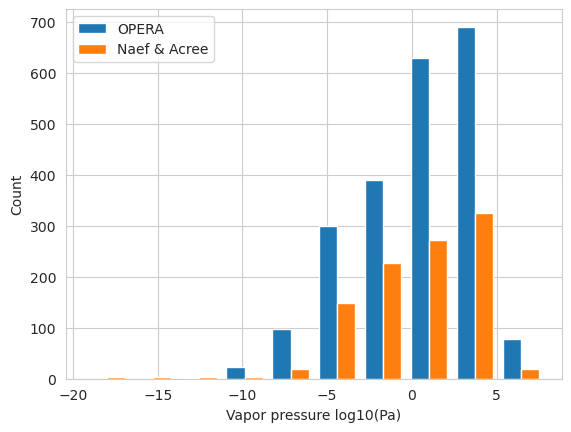

In [5]:
#binned histograms per source
import matplotlib.pyplot as plt
import seaborn as sns
plt.hist([df[df['source'] == 'OPERA']['vp_log10_pa'].values,df[df['source'] == 'Naef_Acree']['vp_log10_pa'].values])
plt.legend(['OPERA','Naef & Acree'])
plt.xlabel('Vapor pressure log10(Pa)')
plt.ylabel('Count')
plt.show()


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na 

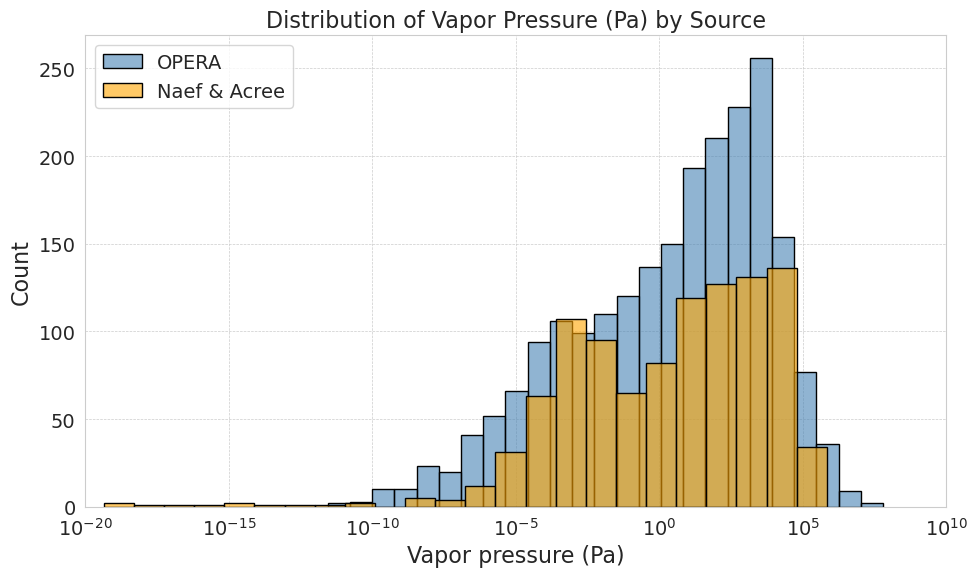

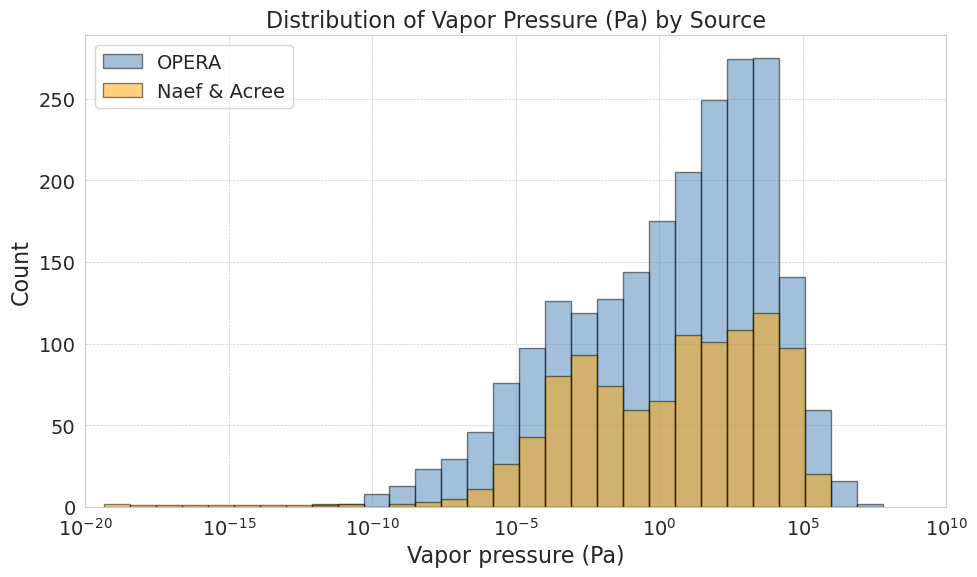

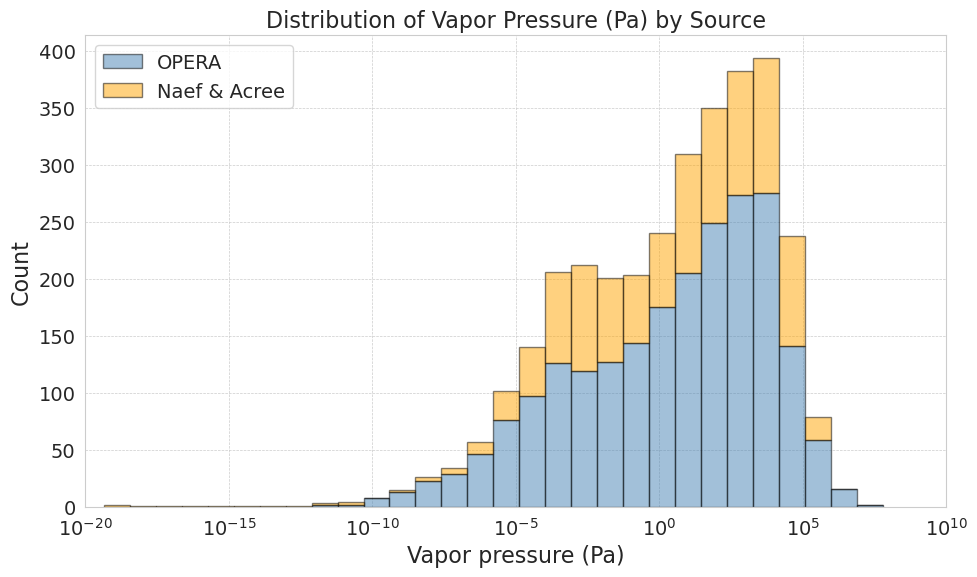

In [31]:

import matplotlib.pyplot as plt
import seaborn as sns

# Set global style for publication-quality figures
sns.set_style('whitegrid')
plt.rcParams.update({
    'font.size': 14,       # General font size
    'axes.labelsize': 16,  # Font size for axis labels
    'axes.titlesize': 16,  # Font size for titles
    'xtick.labelsize': 14, # Font size for x-tick labels
    'ytick.labelsize': 14, # Font size for y-tick labels
    'legend.fontsize': 14, # Font size for legends
})

# Prepare the data for plotting
opera_data = df[df['source'] == 'OPERA']['vp_log10_pa'].values
naef_acree_data = df[df['source'] == 'Naef_Acree']['vp_log10_pa'].values

# Create a histogram plot
plt.figure(figsize=(10, 6))
sns.histplot(opera_data, bins='auto', color='steelblue', label='OPERA', kde=False, alpha=0.6, edgecolor='black')
sns.histplot(naef_acree_data, bins='auto', color='orange', label='Naef & Acree', kde=False, alpha=0.6, edgecolor='black')

# Customize the plot
plt.xlabel('Vapor pressure (Pa)', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.title('Distribution of Vapor Pressure (Pa) by Source')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
#change x labels to 10^x format
# plt.gca().set_xscale('log')
plt.gca().set_xticks(plt.gca().get_xticks())  # Ensure current ticks are updated before setting labels\
xlabels = [f'$10^{{{int(x)}}}$' for x in plt.gca().get_xticks()]
plt.gca().set_xticklabels(xlabels)
plt.xlim(-20, 10)
# Save and show the plot
plt.tight_layout()
plt.savefig('vapor_pressure_histogram.png', dpi=800)
plt.show()


bins = np.histogram(np.hstack((opera_data, naef_acree_data)), bins=30)[1]  # Common bins for both datasets
# Create the histogram plot with adjacent bars
plt.figure(figsize=(10, 6))
plt.hist(opera_data, bins=bins, color='steelblue', alpha=0.5, label='OPERA', edgecolor='black')
plt.hist(naef_acree_data, bins=bins, color='orange', alpha=0.5, label='Naef & Acree', edgecolor='black')
plt.xlabel('Vapor pressure (Pa)', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.title('Distribution of Vapor Pressure (Pa) by Source')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.gca().set_xticks(plt.gca().get_xticks())  # Ensure current ticks are updated before setting labels\
xlabels = [f'$10^{{{int(x)}}}$' for x in plt.gca().get_xticks()]
plt.gca().set_xticklabels(xlabels)
plt.xlim(-20, 10)
plt.tight_layout()
plt.savefig('vapor_pressure_histogram.png', dpi=800)
plt.show()
#and a stacked one
plt.figure(figsize=(10, 6))
plt.hist([opera_data, naef_acree_data], bins=bins, color=['steelblue', 'orange'], alpha=0.5, label=['OPERA', 'Naef & Acree'], edgecolor='black', stacked=True)
plt.xlabel('Vapor pressure (Pa)', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.title('Distribution of Vapor Pressure (Pa) by Source')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.gca().set_xticks(plt.gca().get_xticks())  # Ensure current ticks are updated before setting labels\
xlabels = [f'$10^{{{int(x)}}}$' for x in plt.gca().get_xticks()]
plt.gca().set_xticklabels(xlabels)
plt.xlim(-20, 10)
plt.tight_layout()
plt.savefig('vapor_pressure_histogram_stacked.png', dpi=800)
plt.show()




[56, 54, 52, 50, 48, 46, 44, 42, 40]


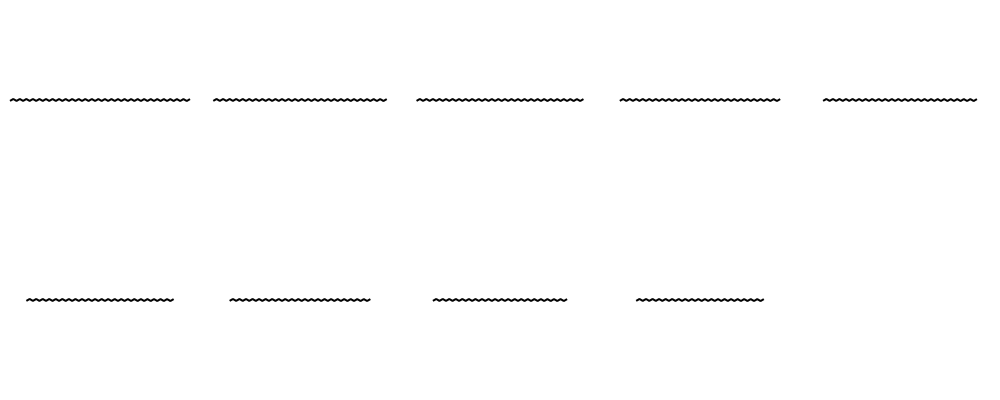

In [148]:
#get the 10 lowest vp data, and draw
df_lowest = df.sort_values('vp_log10_pa').head(9)
df_lowest_molblocks = df_lowest['molblock'].values
from rdkit import Chem
from rdkit.Chem import Draw
mols = [Chem.MolFromMolBlock(mb) for mb in df_lowest_molblocks]
mols_flat = [Chem.MolFromSmiles(Chem.MolToSmiles(m)) for m in mols]
#get numeber of heavy atoms for these
num_atoms = [m.GetNumHeavyAtoms() for m in mols]
print(num_atoms)
img = Draw.MolsToGridImage(mols_flat, molsPerRow=5)
img

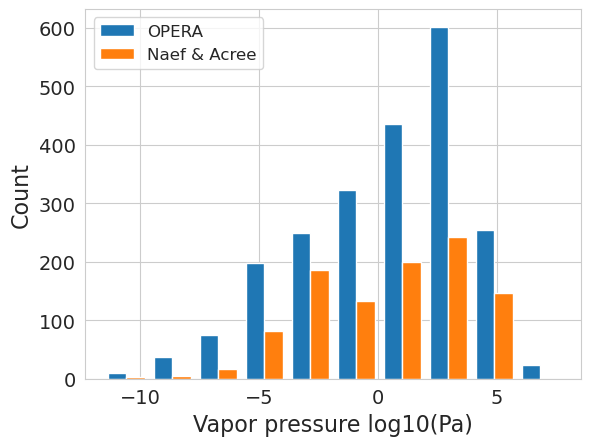

In [149]:
#binned histograms per source
import matplotlib.pyplot as plt
import seaborn as sns
df_no_outliers = df.sort_values('vp_log10_pa').iloc[9:]
plt.hist([df_no_outliers[df_no_outliers['source'] == 'OPERA']['vp_log10_pa'].values,df_no_outliers[df_no_outliers['source'] == 'Naef_Acree']['vp_log10_pa'].values])
plt.legend(['OPERA','Naef & Acree'])
plt.xlabel('Vapor pressure log10(Pa)')
plt.ylabel('Count')
plt.show()

